In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import simpy
from random import sample 
import datetime
from collections import defaultdict

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.policies import policy_saver
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import trajectory

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

Loading trip data...
Data loading complete


In [2]:
#register custom environment
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper parameters

num_iterations = 20 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

epsilon_greedy = 0.01 #should be low for imitation learning, higher for regular q learning

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()

In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy = epsilon_greedy)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)

In [6]:
#create dataset and iterator
#Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
hex count  114
Number of trips generated: 2065


In [8]:
#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [9]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            print(int(np.array([state_list[i]["observation"]])[0][1]))
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

driver reward  0
17
[[41.    17.    13.259 41.339]]
17
[[35.8        17.         21.69305416  2.89500107]]
18
[[ 6.9   18.     8.267 24.406]]
18
[[11.2        18.         16.78411937 44.19268273]]
18
[[12.2   18.     6.179 42.997]]
18
[[11.4        18.         16.18057588 30.95480664]]
18
[[11.9        18.          4.06001128 18.87080949]]
18
[[13.8        18.         18.24892689 29.26114511]]
18
[[ 9.3        18.         13.64024886  5.46952961]]
18
[[28.3        18.         36.22431501 13.68015428]]
19
[[12.         19.         25.4643841   0.21765846]]
19
[[26.         19.         34.09269156 22.183236  ]]
20
[[25.5        20.         33.07657662 57.45432849]]
20
[[18.5        20.         20.27288197 37.15744769]]
20
[[34.6        20.         40.86358428 54.99283375]]
23
[[24.1        23.         26.25057019 34.37584281]]
6
[[15.5         6.         14.04420361 48.12983091]]
7
[[12.8         7.         12.92350055 45.00355206]]
8
[[11.8         8.         29.40595935 45.03764546]]
8

[[24.4        16.          0.10229848 39.06721457]]
16
[[25.5        16.         29.41969567 31.09680045]]
16
[[21.7        16.         26.39688689 11.83349894]]
16
[[ 7.5        16.          5.61311585 16.81762233]]
17
[[15.9        17.         22.10784613 22.58318648]]
17
[[ 9.2        17.          8.30470949 45.4297278 ]]
17
[[30.5        17.         31.63383259 56.73750295]]
18
[[17.8        18.         17.34468028 39.99001525]]
18
[[ 3.5        18.          5.36333367 25.53580048]]
18
[[39.1        18.         42.44233308 47.87757039]]
20
[[39.3        20.          9.5862035  25.91588037]]
20
[[ 6.3        20.         13.9514661  22.05970509]]
20
[[ 9.5        20.         20.80952779 18.75834756]]
21
[[21.8        21.          2.24974831  1.01665192]]
21
[[22.         21.         26.64330655  5.07963209]]
7
[[37.7         7.         48.22548598 28.75891811]]
9
[[30.8         9.         16.77829166 59.67122122]]
10
[[24.7        10.         29.87869105 32.51934235]]
12
[[19.7      

[[30.3   14.     7.935 23.43 ]]
14
[[ 7.5        14.          5.97195025 42.7246678 ]]
14
[[ 3.5        14.          2.56503248 40.03697322]]
14
[[11.5        14.         17.55956408 32.73308847]]
14
[[18.4        14.         24.44254527 36.07613612]]
14
[[31.9        14.         47.74296451 39.47711608]]
8
[[30.9         8.         36.28279927  2.55655953]]
16
[[15.6        16.         36.96398517  0.70606477]]
17
[[11.7        17.         27.59223862 14.90689626]]
17
[[14.9        17.         35.27602757  5.93723314]]
18
[[19.4   18.     3.47  29.403]]
18
[[19.6        18.          1.45428519 53.62968152]]
18
[[24.7        18.         31.02152104 58.7406896 ]]
18
[[ 4.7        18.         15.87127655 58.15118413]]
19
[[ 5.8        19.          0.89022445 44.11137064]]
19
[[36.9        19.         39.00984812 55.1084025 ]]
20
[[ 6.1        20.         21.73493959 54.98660585]]
20
[[18.7        20.         20.20419759 30.4074981 ]]
20
[[21.5        20.         23.68661698 41.65475922]]

[[ 3.          6.          8.01756098 21.08958716]]
7
[[20.2         7.         14.4202557  47.98164379]]
8
[[20.5         8.         24.13852586 57.20215677]]
8
[[14.1         8.         22.46327932 45.40796447]]
8
[[16.1         8.         35.48454594 58.78400774]]
11
[[ 5.6        11.         24.18854554 58.32086825]]
11
[[13.    11.     3.448 52.961]]
11
[[ 4.5        11.          0.97814029 58.68774452]]
11
[[51.3        11.         53.08683454 30.59529774]]
6
[[15.          6.         43.30866944 42.39959357]]
6
[[37.          6.         33.88321734  2.03583451]]
16
[[31.1   16.     8.194 26.572]]
17
[[45.1        17.         49.32242968 11.43843931]]
18
[[18.7   18.    46.199 41.676]]
19
[[13.6        19.         42.97472736 24.74562871]]
20
[[13.9        20.         48.61892407 40.5125762 ]]
7
[[ 8.7         7.         24.48464401 51.07345448]]
7
[[19.3         7.         11.92043775 26.88439961]]
7
[[12.2         7.         14.75211988 22.34912463]]
7
[[34.9         7.        

[[ 1.5   14.     7.725 49.382]]
14
[[ 0.9        14.          5.37773555 46.7894104 ]]
14
[[12.3        14.          6.09407301 39.20421508]]
14
[[ 7.7        14.          8.09139952 56.39822596]]
14
[[52.6        14.         52.74487109 42.06358352]]
12
[[13.         12.         47.40027813 49.03768341]]
1
[[17.6    1.    27.044 54.116]]
6
[[21.6         6.          2.00154659 27.03160503]]
7
[[23.3         7.         13.23350399  9.26523148]]
7
[[24.7         7.          6.32041093 37.59860323]]
7
[[17.1         7.         21.15444329 39.66713924]]
7
[[ 7.7         7.          6.0309583  47.85015072]]
7
[[ 6.2         7.          2.02029022 31.30208042]]
7
[[18.8         7.         15.73917326  4.72920031]]
7
[[40.9         7.         35.23003551 49.30883132]]
7
[[19.1    7.     3.864 46.042]]
8
[[ 8.          8.          8.55791629 42.68770719]]
8
[[17.8         8.         21.97360834 36.60261539]]
8
[[27.3         8.         53.6252407  40.74142265]]
8
[[19.2         8.         57.

[[10.1         7.         51.42492547 31.41858381]]
18
[[14.2        18.         37.04940125 35.90829558]]
18
[[16.3        18.         27.89176333 53.3153328 ]]
19
[[ 7.         19.         21.28416393 55.29096411]]
19
[[29.3        19.          1.77321695 22.50626178]]
19
[[ 8.         19.         11.40618556 14.57833143]]
19
[[22.6        19.         20.78492569 31.03410354]]
19
[[ 2.6        19.         13.94866174 27.92094267]]
19
[[ 9.9        19.         11.41538465 35.86751388]]
20
[[16.9        20.         23.78259745 22.51758585]]
20
[[19.8        20.         14.36002327 45.12697413]]
20
[[ 6.2        20.         10.96609107 46.89001877]]
20
[[25.6       20.        13.5062731 24.8084674]]
20
[[13.3        20.          4.33871478 12.55485624]]
20
[[16.8        20.         18.05448765 14.13549853]]
21
[[ 6.2        21.          9.75219696 15.29099138]]
21
[[41.5        21.         35.01728154  2.53949762]]
21
[[ 8.6        21.         32.32811643 16.04074142]]
driver reward  -8

/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
#evaluate a trained policy with respect to a pre-generated static environment

pickup_distance_brackets = [1, 2, 3, 4, 6, 10]
trip_distance_brackets = [5, 10, 15, 25, 35, 50]
    
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i
    
#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
    pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
    pickup_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                #print(np.array([state_list[i]["observation"]]))
                pickup_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            pickup_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", pickup_trip_counts )
    for j in range(len(pickup_distance_brackets)+1):
        pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    print (pickup_accepted_trips)
    print(pickup_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

driver reward  0
driver reward  771.52
driver reward  -1921.0400000000004
driver reward  -53.27999999999915
driver reward  174.56000000000031
driver reward  442.20000000000016
driver reward  -689.9199999999992
driver reward  -112.91999999999948
driver reward  -42.279999999999646
driver reward  -1403.3199999999986
driver reward  260.52000000000055
driver reward  -432.2799999999989
driver reward  -141.7999999999996
driver reward  -144.59999999999934
driver reward  294.8400000000008
driver reward  -842.7599999999998
driver reward  778.7200000000007
driver reward  -183.55999999999926
driver reward  186.55999999999997
driver reward  -185.27999999999957
total reward  -3244.1199999999913
trips [  11.   25.   36.   40.  122.  290. 1342.]
[  11.   25.   36.   40.  122.  290. 1342.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [11]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

driver reward  0
17
17
18
[[ 6.9   18.     8.267 24.406]]
18
18
18
18
18
18
18
19
19
20
20
20
23
6
7
8
8
9
8
8
8
8
8
8
8
8
9
9
[[ 2.          9.          8.93147984 45.4664708 ]]
9
9
9
9
10
10
[[ 4.1        10.         24.23029796 43.544428  ]]
10
10
[[ 0.9   10.    11.959 28.843]]
10
driver reward  -371.67999999999995
4
6
6
7
8
8
8
9
10
16
[[ 5.4        16.         34.08058012 38.86170935]]
18
19
20
20
21
[[ 1.6        21.         15.94513897 54.27606934]]
22
1
1
2
7
7
8
14
14
14
14
15
[[ 4.5        15.          0.88454543 35.36798541]]
15
[[ 4.3        15.         19.75092739 43.44362036]]
15
[[ 5.    15.    13.011 60.   ]]
15
15
15
15
15
15
15
[[ 5.5        15.          9.00872621 21.59414288]]
15
16
16
16
18
[[ 4.7        18.         28.75722922 42.33734792]]
18
19
19
19
[[ 3.4   19.     3.872 15.86 ]]
19
19
20
22
[[10.2        22.         19.15902631 11.43091535]]
0
8
[[ 3.4    8.    11.089 34.339]]
8
8
12
13
13
13
13
13
14
14
14
14
14
14
14
14
14
15
15
15
16
16
[[ 0.7        16. 

16
16
16
16
17
17
17
[[ 6.1        17.         14.25557963 29.54643258]]
17
17
18
18
18
18
18
18
[[ 5.6   18.    25.175 49.818]]
19
19
[[ 1.2        19.          6.66753641 25.4132403 ]]
19
19
19
19
19
[[ 7.6        19.         13.50719977 45.61878189]]
19
[[ 0.7        19.          6.89556005 42.21607782]]
19
19
20
20
20
20
[[ 6.9        20.         18.36878499 33.99111287]]
20
20
[[ 6.7        20.          2.56568515 11.76236537]]
20
20
20
21
[[ 4.9        21.          8.47599068 22.06456925]]
21
21
21
[[ 7.1        21.         14.25777529 43.17022028]]
21
7
8
8
8
8
8
8
[[ 3.2         8.          8.03836387 39.26187185]]
8
9
9
9
10
10
10
10
11
12
12
13
13
13
13
13
13
13
13
13
16
16
16
18
[[ 7.8        18.         17.07550524 26.70112782]]
18
18
19
[[ 4.8        19.          7.7273427  23.33051566]]
19
19
19
20
20
20
20
20
20
20
20
21
21
8
8
8
8
8
9
9
9
9
10
10
11
11
[[ 2.1        11.          2.79212448 52.77916688]]
11
11
12
12
[[ 2.9   12.     6.517 40.256]]
12
[[ 4.8   12.     7.8

22
23
0
8
8
[[ 3.4    8.    26.836 54.625]]
8
8
9
9
9
9
10
14
14
14
14
14
[[ 5.    14.    21.734 35.943]]
14
15
15
[[ 6.8        15.         19.88457564 23.08297673]]
15
16
16
[[ 2.         16.          4.2299077   9.93291869]]
16
16
16
17
18
18
18
[[ 8.1        18.          1.23920641 22.55706886]]
18
19
19
19
20
20
[[ 4.6        20.         20.29920558 23.23094683]]
20
20
[[ 3.9   20.     4.063 22.724]]
20
[[ 3.3   20.     4.312 26.743]]
21
[[ 8.6        21.          8.97023538 24.32103094]]
21
21
22
[[ 9.3        22.          3.27273846 30.2969486 ]]
22
driver reward  -766.24
1
2
7
7
7
7
7
8
8
8
8
8
8
8
9
16
8
9
9
9
9
9
10
[[ 0.8        10.         32.70100828 33.0991141 ]]
10
21
[[ 8.6        21.         53.10007355 51.0177305 ]]
12
13
13
14
14
[[ 2.         14.         22.01038187 31.52138353]]
15
15
[[ 2.8   15.     3.742 15.039]]
15
17
17
17
[[ 6.    17.     9.845 36.402]]
17
17
17
18
18
19
19
20
7
7
8
8
8
8
8
8
8
[[ 0.6         8.          3.65058622 14.40906529]]
9
9
9
10
[[ 3

/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()

## Reinforcement Learning Q-Learning

In [13]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

## Imitation Learning

### load data

In [25]:
#imitation learning strategy
#parse pickme data into trajectories
#pickup distance ignored since it is nto available in dataset
#load data
import pandas as pd 
import math
from tqdm import tqdm

driver_actions_table =  pd.read_csv("../data/driver-action.csv") 
trip_data =  pd.read_csv("../data/trip-data.csv") 

In [26]:
trip_data.head(10)

,passengerslogid,driverid,pickuplatitude,pickuplongitude,droplatitude,droplongitude,actualpickuptime,paymentmethod,isdirectionalhire,distance,travelstatus,taximodelid,createddate
0,212553104,188,6.03305,80.2168,6.07534,80.2346,NaN,1,NaN,NaN,11,1,2020-02-01 00:08:28.0
1,212554705,188,6.93233,79.8492,6.91947,79.9114,NaN,1,NaN,NaN,12,1,2020-02-01 00:25:27.0
2,212555287,0,6.93257,79.8486,6.82994,79.9101,NaN,1,NaN,NaN,11,1,2020-02-01 00:30:43.0
3,212557334,18930,6.90514,79.8788,6.89894,79.8771,2020-02-01 01:00:37.0,1,NaN,1.28,1,1,2020-02-01 00:53:54.0
4,212558261,117344,6.88920,79.8895,6.91505,79.9531,2020-02-01 01:11:07.0,1,NaN,9.78,1,1,2020-02-01 01:06:08.0
5,212560424,0,7.21436,79.8471,7.22546,79.8520,NaN,1,NaN,NaN,11,1,2020-02-01 01:52:20.0
6,212565638,0,6.88655,79.8583,6.92075,79.8561,NaN,2,NaN,NaN,11,1,2020-02-01 05:36:30.0
7,212565684,107426,6.84864,79.9635,6.85434,79.8923,2020-02-01 05:42:07.0,1,NaN,9.80,1,1,2020-02-01 05:37:34.0
8,212567228,16925,6.86133,79.8781,6.85090,79.8661,2020-02-01 06:22:50.0,1,NaN,2.28,1,1,2020-02-01 06:17:46.0
9,212571010,0,7.03675,79.9023,7.02326,79.9092,NaN,1,NaN,NaN,11,1,2020-02-01 07:19:46.0


In [27]:
driver_actions_table.head(10)

,trip_id,created_driver_id,assigned_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type
0,212552700,0,38457.0,38457.0,38457.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
1,212552700,0,79308.0,79308.0,79308.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
2,212552700,0,60511.0,60511.0,60511.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
3,212552700,0,11251.0,11251.0,11251.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
4,212552700,0,22304.0,22304.0,22304.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
5,212553052,0,66075.0,66075.0,66075.0,66075.0,NaN,NaN,NaN,NaN,1,2020-02-01,AFTER_ACCEPTED
6,212553052,0,25440.0,25440.0,25440.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
7,212553052,0,40092.0,40092.0,40092.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
8,212553052,0,56333.0,56333.0,56333.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
9,212553052,0,75565.0,75565.0,75565.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL


### data preprocessing

In [28]:
#drop duplicated rows
driver_actions_table.drop_duplicates(keep = 'first', inplace = True)

#drop rows with assigned driver null
driver_actions_table.drop(driver_actions_table[driver_actions_table['assigned_driver_id'].isnull()].index, inplace=True)

In [29]:
#make a double index
driver_actions_table[['trip_id', 'assigned_driver_id']] = driver_actions_table[['trip_id', 'assigned_driver_id']].apply(pd.to_numeric).applymap(np.int64).astype(str)
driver_actions_table.set_index(['assigned_driver_id', 'trip_id'], inplace=True)
driver_actions_table.head()

,,created_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type
assigned_driver_id,trip_id,,,,,,,,,,,
38457,212552700,0,38457.0,38457.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
79308,212552700,0,79308.0,79308.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
60511,212552700,0,60511.0,60511.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
11251,212552700,0,11251.0,11251.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
22304,212552700,0,22304.0,22304.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL


In [30]:
#get the week number
driver_actions_table['created_date'] = pd.to_datetime(driver_actions_table['created_date'])

def getWeekNumber(x):
    if datetime.date(2020, 2, 3) <= x <= datetime.date(2020, 2, 9):
        return 1
    elif datetime.date(2020, 2, 10) <= x <= datetime.date(2020, 2, 16):
        return 2
    elif datetime.date(2020, 2, 17) <= x <= datetime.date(2020, 2, 23):
        return 3
    elif datetime.date(2020, 2, 24) <= x <= datetime.date(2020, 3, 1):
        return 4
    else:
        return 0

driver_actions_table['week_no'] = driver_actions_table['created_date'].apply(getWeekNumber)

In [31]:
#drop week number 0 trips
driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==0].index, inplace=True)

In [32]:
#temporary limit
driver_actions_table = driver_actions_table.head(100000)

In [33]:
#count accepted trips within the week

def count_accepted_trips(df, week_num):
    trip_counts = defaultdict(int)
    for index, row in tqdm(df[(df['week_no']==week_num)].iterrows()):
        driver_id = index[0]
        df.at[index,'accepted_trip_count'] = trip_counts[driver_id]
        if not np.isnan(row['accepted_driver_id']):
          trip_counts[driver_id] += 1

driver_actions_table['accepted_trip_count'] = 0

for week in tqdm(range(1,5)):
    count_accepted_trips(driver_actions_table,week)

  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.72it/s]
411it [00:00,  2.46it/s]
824it [00:00,  3.51it/s]
1237it [00:00,  5.02it/s]
1637it [00:00,  7.16it/s]
2050it [00:01, 10.23it/s]
2449it [00:01, 14.60it/s]
2844it [00:01, 20.82it/s]
3256it [00:01, 29.67it/s]
3670it [00:01, 42.26it/s]
4081it [00:01, 60.11it/s]
4485it [00:01, 85.32it/s]
4884it [00:01, 120.78it/s]
5299it [00:01, 170.41it/s]
5702it [00:01, 239.06it/s]
6113it [00:02, 333.19it/s]
6518it [00:02, 459.34it/s]
6920it [00:02, 624.12it/s]
7316it [00:02, 831.72it/s]
7705it [00:02, 1083.43it/s]
8091it [00:02, 1381.09it/s]
8500it [00:02, 1723.12it/s]
8891it [00:02, 2023.83it/s]
9300it [00:02, 2383.96it/s]
9718it [00:03, 2735.50it/s]
10126it [00:03, 3034.34it/s]
10525it [00:03, 3262.80it/s]
10933it [00:03, 3470.29it/s]
11350it [00:03, 3652.44it/s]
11756it [00:03, 3731.99it/s]
12165it [00:03, 3831.50it/s]
12569it [00:03, 3876.45it/s]
12976it [00:03, 3931.14it/s]
13380it [00:03, 3747.29it/s]
13766it [00:04, 37

93501it [00:26, 3443.34it/s]
93850it [00:26, 3454.85it/s]
94212it [00:26, 3500.97it/s]
94579it [00:26, 3547.51it/s]
94940it [00:27, 3564.06it/s]
95297it [00:27, 3560.30it/s]
95654it [00:27, 3562.29it/s]
96011it [00:27, 3341.87it/s]
96376it [00:27, 3426.52it/s]
96743it [00:27, 3495.39it/s]
97098it [00:27, 3509.52it/s]
97451it [00:27, 3469.02it/s]
97809it [00:27, 3501.31it/s]
98170it [00:27, 3532.63it/s]
98537it [00:28, 3571.98it/s]
98895it [00:28, 3560.69it/s]
99252it [00:28, 3545.62it/s]
99619it [00:28, 3581.53it/s]
100000it [00:28, 3514.48it/s][A
 25%|██▌       | 1/4 [00:28<01:25, 28.55s/it]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:28<00:00,  7.14s/it]


In [38]:
#get trips till reward
def getTripsTillReward(x):
    if x < 20:
        return 20-x
    elif x < 30:
        return 30-x
    elif x < 50:
        return 50-x
    elif x < 75:
        return 75-x
    elif x < 100:
        return 100-x
    elif x < 125:
        return 125-x
    else:
        return 0

driver_actions_table['trips_till_reward'] = driver_actions_table['accepted_trip_count'].apply(getTripsTillReward)

In [39]:
driver_behaviours = []

#trajectory format - trip distance, time of day, drop location_long, drop_location_lat, (trips_till_weekly_reward)

#MANUAL and SYSTEM_REJECTED count as rejected, null counts as acccepted

bool_accepted_series = pd.notnull(driver_actions_table["accepted_driver_id"])  #if a trip was rejected after accepting, it is considered acceptance within the scope
accepted_driver_actions = driver_actions_table[bool_accepted_series]
bool_rejected_series = pd.isnull(driver_actions_table["accepted_driver_id"]) & pd.notnull(driver_actions_table["rejected_driver_id"]) #trip neither accepted nor rejected were removed
rejected_driver_actions = driver_actions_table[bool_rejected_series]
print("total", len(driver_actions_table.index))
print("accepted", len(accepted_driver_actions.index))
print("rejected", len(rejected_driver_actions.index))
print("trips", len(trip_data.index))

total 100000
accepted 33049
rejected 59929
trips 4046020


In [40]:
# TODO distance scale
# for rides without distance, estimate distance based on l2 distance and scaling 
# factor calculated from ratio between l2 distance and real distance
scaling_factor = 1.3

#get l2 distance (assume that locations are close to equator)
def l2_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))*111 #mult by 111 to turn cordinates to km

In [41]:
# lookup drop location, trip distance, time from trip_data
def get_trip_data(trips, trip_id):
    trip = trips.loc[trips['passengerslogid'] == trip_id]
    #if exactly one record is found
    if (len(trip.index)) ==1:
        #trip = trip["droplatitude"]
        for tr in trip.iterrows():
            lat  = tr[1]["pickuplatitude"]
            long  = tr[1]["pickuplongitude"]
            time  = pd.to_datetime(tr[1]["createddate"])
            
            #check if distance is available
            if (math.isnan(tr[1]["distance"])):
                distance = scaling_factor * l2_dist(tr[1]["pickuplatitude"],
                                                   tr[1]["droplatitude"],
                                                   tr[1]["pickuplongitude"],
                                                   tr[1]["droplongitude"])                
            else:

                distance  = tr[1]["distance"]
            return {
                "drop_lat": lat,
                "drop_long": long,
                "time": time,
                "trip_dist": distance
            }
    else:
        return None
    #print(trip)


get_trip_data(trip_data, 212554705)

{'drop_lat': 6.93233,
 'drop_long': 79.8492,
 'time': Timestamp('2020-02-01 00:25:27'),
 'trip_dist': 9.165287626627732}

In [97]:
# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions ={}
count = 0
#loop through accepted trips
for id, row in tqdm(accepted_driver_actions.iterrows()):
    count+=1
    if count == 10000: #temporary limit for testing
        break
        
    #print(row["trip_id"])
    observation = get_trip_data(trip_data, int(id[1]))
    if observation is not None:
        observation.update({"trips_till_reward": int(row["trips_till_reward"])})
    else:
        count-=1
        continue
    action = {"accept": 1, "observation": observation}
    key = str(int(row["accepted_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
        
#loop through rejected trips
count = 0

for id, row in tqdm(rejected_driver_actions.iterrows()):
    count+=1
    if count == 10000:
        break
        
    #print(row["trip_id"])
    observation = get_trip_data(trip_data, int(id[1]))
    if observation is not None:
        observation.update({"trips_till_reward": int(row["trips_till_reward"])})
    else:
        count-=1
        continue
    action = {"accept": 0, "observation": observation}
    if (math.isnan(row["rejected_driver_id"])):
        continue
    key = str(int(row["rejected_driver_id"]))
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)

10007it [01:09, 144.78it/s]
10003it [01:00, 166.46it/s]


In [98]:
#sort action in order (based on time)

#remove invalid values
refined_driver_actions = {}
for driver in driver_actions:
    refined_actions = []
    for action in driver_actions[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions.append(action)
        except:
            continue
    refined_driver_actions[driver] = refined_actions
    
for driver in refined_driver_actions:
        refined_driver_actions[driver] = sorted(refined_driver_actions[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in refined_driver_actions:
    for action in refined_driver_actions[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

In [99]:
driver_actions = refined_driver_actions
del refined_driver_actions
print(driver_actions["66075"])

[{'accept': 0, 'observation': {'drop_lat': 6.71116, 'drop_long': 79.9157, 'time': 22, 'trip_dist': 11572.427069443602, 'trips_till_reward': 20}}, {'accept': 1, 'observation': {'drop_lat': 6.71175, 'drop_long': 79.9076, 'time': 22, 'trip_dist': 2.95, 'trips_till_reward': 20}}]


### dataset preparation

In [101]:
# create trajectory collection from pickme trajectory set
#reward is set to 0 because it is  not available in the dataset and at this stage the agent does not explore

driver_trajectories = []

#loop through drivers
for key in driver_actions:
    #driver must have at least 2 rides to create a trajectory
    if len(driver_actions[key]) > 1:
        states = []
        actions = []

        #convert states directly to tf timesteps
        for i in range(len(driver_actions[key])):
            #create time step
            obs = driver_actions[key][i]["observation"]
            obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"], obs["trips_till_reward"]]
            if i == 0:
                #initial trajectory
                state_tf = ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            elif i < (len(driver_actions[key]) - 1):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))
            else:
                #terminating tranjectory
                state_tf = ts.TimeStep(tf.constant([2]), tf.constant([0.0]), tf.constant([0.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            #create action
            #action = state_list[i]["action"]
            action = policy_step.PolicyStep(tf.constant([driver_actions[key][i]["accept"]], dtype=tf.int64), ())
            #print (action)
            states.append(state_tf)
            actions.append(action)

        for j in range(len(states)-1):
            present_state = states[j]
            #print(present_state)
            next_state = states[j+1]
            action = actions[j]

            traj = trajectory.from_transition(present_state, action, next_state)
            #print(action)
            # Add trajectory to the replay buffer
            driver_trajectories.append(traj)
            #replay_buffer.add_batch(traj)
            #print(traj)

print(len(driver_trajectories))
#cache trajectories as json to disk?

#convert trajectories to tf agents format

14388


In [102]:
#add subset of trajectorise to replay buffer
def collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories):
    #sample from trajectories
    sample_trajectories = sample(driver_trajectories, num_trajectories)
    for traj in sample_trajectories:
        replay_buffer.add_batch(traj)

In [103]:
num_trajectories = 1000
#collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)

### model training - WIP

In [104]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        
        #imitation learning
        collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)
        
        #regular q learning
        #collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()
        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))
        
        #evaluation
        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policdriver_trajectoriesy_%d' % step)
        
        
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 2002
hex count  114
Number of trips generated: 1876
tf.Tensor(-3637.0598, shape=(), dtype=float32)
 Average Return = -3637.059814453125
hex count  114
Number of trips generated: 1932
hex count  114
Number of trips generated: 2030
tf.Tensor(-2109.32, shape=(), dtype=float32)
step = 5: Average Return = -2109.320068359375
evaluation
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=3941.3445>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([2.36118851e+02, 1.15629227e+02, 1.34437418e+00, 5.76882080e+02,
       4.74026489e+01, 2.81590179e+02, 3.51197227e+04, 7.78092499e+01,
       3.23787070e+04, 1.65760815e+00, 5.90755463e-01, 1.84445884e-02,
       2.75175507e+02, 1.16466255e+02, 5.30045471e+01, 3.56829141e+04,
       4.43157703e-01, 1.04265755e+02, 2.66719543e+02, 2.57805735e-01,
       4.97798386e+01, 6.90846802e+02, 4.83433495e+01, 1.55966675e+02,
       3.23533477e+04, 7.76782913e+01, 2

In [66]:
# TODO
# add trips till weekly reward observation
# add evaluation
# mix with regular q learning
# visualize results

Text(0.5, 0, 'Iterations')

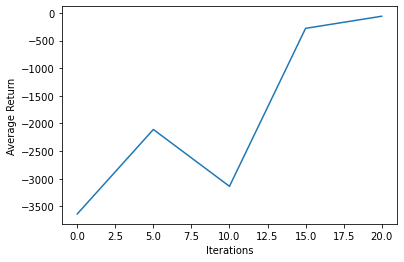

In [105]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)